# Final Lab

In [ ]:
import pandas as pd
import numpy as np

# EDA

I first did a log transform on the target variable because it was extremely right skewed. You can see that the resulting transform looks far more normally distributed and should be easier to work with using regression models.

First I trained a linear regression model using a scaled and standardized x so that we could see what elements were probably the most important based off of coefficients. If we don't standardize and scale the features then the coefficients become a lot harder to compare because a small coefficient may actually be a very important if the feature is on a very large scale. I removed insignificant variables iteratively based off of the p-values. Finally, I chose to keep elements that had an absolute coefficient of at least 0.01. 

Next I trained a decision tree regressor also using scaled and standardized x. I did a grid search over several cpp_alpha values to prune features and improve our tree. We actually see a significant improvement in both R^2 and mean_squared_error metrics between the tuned tree and the initial vanilla tree (-0.8 to 0.09 R^2 and 1.57 to 0.78 MSE). This was not the case with the linear regression model. After tuning the tree, I used feature importance rankings to sort features from the most important to least important. 

I chose the top 5 absolutely largest coefficients from linear regression and decision tree to plot against the target variable. When plotting against the target variable, if the feature is binary, I used a box and whisker plot, and I used a scatterplot if the feature was continuous.

The top 5 predictors based on absolute coefficients from the linear regression model were: LDA_0, LDA_1, ... LDA_4. The top 5 predictors based on the feature importance scores from the decision tree were: N_unique_tokens, data_channel_is_entertainment, data_channel_is_socmed, data_channel_is_tech, and kw_max_max.

<Axes: >

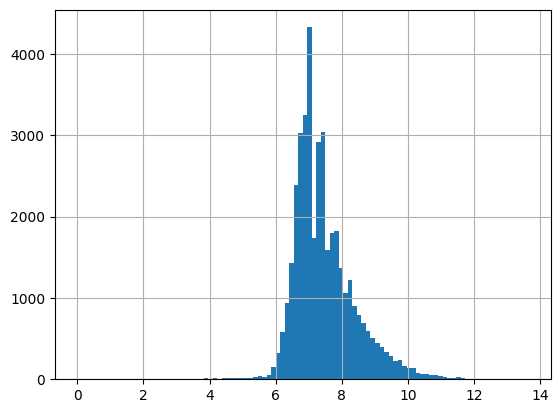

In [2]:
dataset = pd.read_csv('https://richardson.byu.edu/220/OnlineNewsPopularity.csv')
shares = dataset[' shares']
logged_y = shares.apply(lambda x: 0 if x == 0 else np.log(x))
logged_y.hist(bins=100)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

X = dataset.drop(['url', ' timedelta', ' shares'], axis=1)
x_scaler = StandardScaler()
x_scaler.fit_transform(X)
X_scaled = x_scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, logged_y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)
print("Initial R^2: ", model.score(X_test, y_test))
print("Initial MSE: ", mean_squared_error(y_test, model.predict(X_test)))
# iterate over the p scores and remove them one at a time until the p score is less than 0.05
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
p_values = sm.OLS(y_train, X_train).fit().pvalues
p_values = p_values.drop('const')
while p_values.max() >= 0.05:
    print("dropping: ", p_values.idxmax())
    X_train = X_train.drop(p_values.idxmax(), axis=1)
    X_test = X_test.drop(p_values.idxmax(), axis=1)
    model.fit(X_train, y_train)
    p_values = sm.OLS(y_train, X_train).fit().pvalues
    p_values = p_values.drop('const')



X_test = sm.add_constant(X_test)

print("Final score: ", model.score(X_test, y_test))
print("Final MSE: ", mean_squared_error(y_test, model.predict(X_test)))
# print the model coefficients next to the column names
coefficients = pd.Series(model.coef_, index=X_train.columns)
# sort the coefficients from absolute largest to smallest
coefficients = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)
# keep only the coefficients absolutely greater than 0.01
coefficients = coefficients[coefficients.abs() > 0.01]
print(coefficients)
print(len(coefficients))

Initial R^2:  0.13379452428058713
Initial MSE:  0.7603527329944876
dropping:   min_negative_polarity
dropping:   avg_positive_polarity
dropping:   LDA_02
dropping:   abs_title_sentiment_polarity
dropping:   n_non_stop_words
dropping:   max_negative_polarity
dropping:   self_reference_min_shares
dropping:   global_sentiment_polarity
dropping:   kw_max_max
dropping:   weekday_is_monday
dropping:   weekday_is_friday
dropping:   global_rate_negative_words
dropping:   n_non_stop_unique_tokens
dropping:   rate_negative_words
dropping:   data_channel_is_world
dropping:   max_positive_polarity
dropping:   rate_positive_words
dropping:   num_videos
Final score:  0.13388813527086385
Final MSE:  0.7602705615302214
 is_weekend                      -6.174322e+10
 weekday_is_sunday                4.640636e+10
 weekday_is_saturday              4.410151e+10
const                             2.757233e+05
 kw_avg_avg                       4.331401e-01
 kw_max_avg                      -2.486976e-01
 LDA_

In [4]:
from sklearn.tree import DecisionTreeRegressor
# figure out which cpp_alpha to use
from sklearn.model_selection import GridSearchCV

parameters = {'ccp_alpha': [0.001, 0.01, 0.1, 1, 10]}
tree = DecisionTreeRegressor()
model = GridSearchCV(tree, parameters)
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_scaled, logged_y, test_size=0.2)
model.fit(X_tree_train, y_tree_train)

initial_model = DecisionTreeRegressor()
initial_model.fit(X_tree_train, y_tree_train)
print("initial score: ", initial_model.score(X_tree_test, y_tree_test))
print("initial mse: ", mean_squared_error(y_tree_test, initial_model.predict(X_tree_test)))
print(model.best_params_)
print("Final score: ", model.score(X_tree_test, y_tree_test))
print("Final mse: ", mean_squared_error(y_tree_test, model.predict(X_tree_test)))
# print the feature importances
model = DecisionTreeRegressor(ccp_alpha=0.001) # 0.001 was the best ccp_alpha
model.fit(X_tree_train, y_tree_train)
importances = pd.Series(model.feature_importances_, index=X_tree_train.columns)
importances = importances[importances > 0.01]
print(importances)
print(len(importances))


initial score:  -0.8131425253583766
initial mse:  1.5218730032987293
{'ccp_alpha': 0.001}
Final score:  0.10315463840197181
Final mse:  0.7527730031481942
n_tokens_content                 0.012404
data_channel_is_entertainment    0.048342
data_channel_is_socmed           0.025988
data_channel_is_tech             0.070005
kw_max_max                       0.017780
kw_max_avg                       0.059805
kw_avg_avg                       0.503665
self_reference_avg_sharess       0.176639
is_weekend                       0.065466
dtype: float64
9


Decision Tree


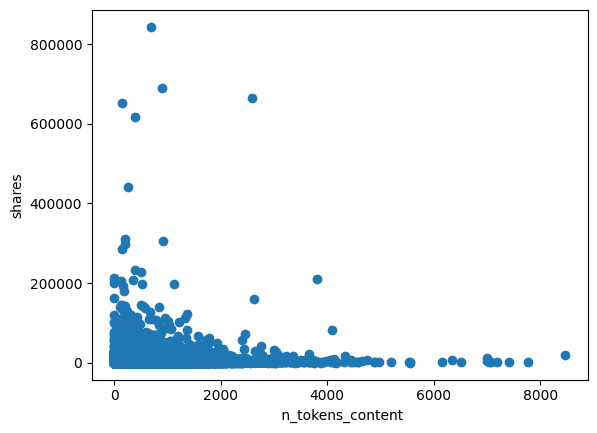

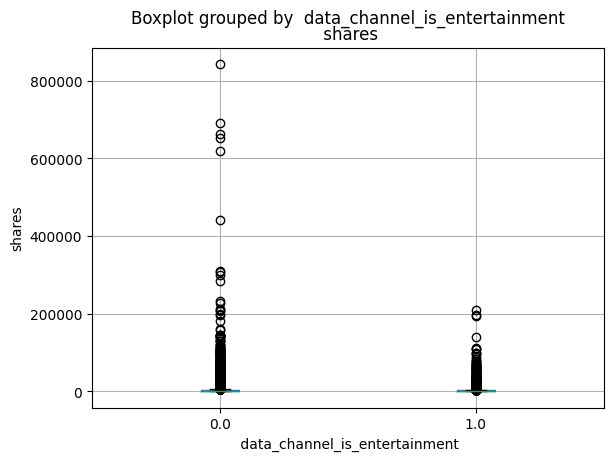

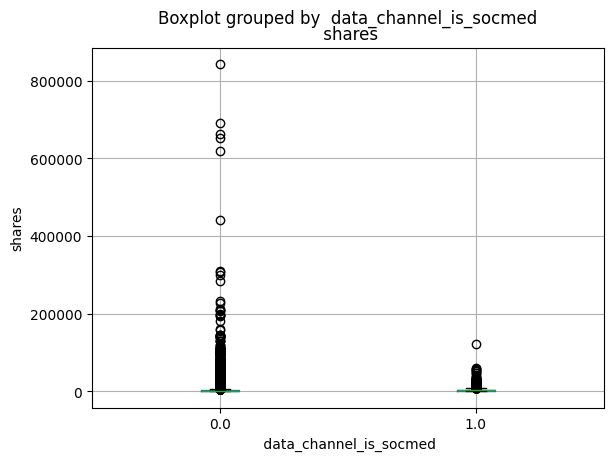

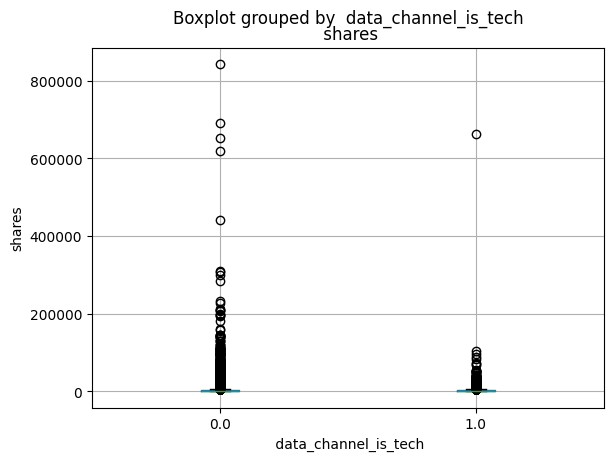

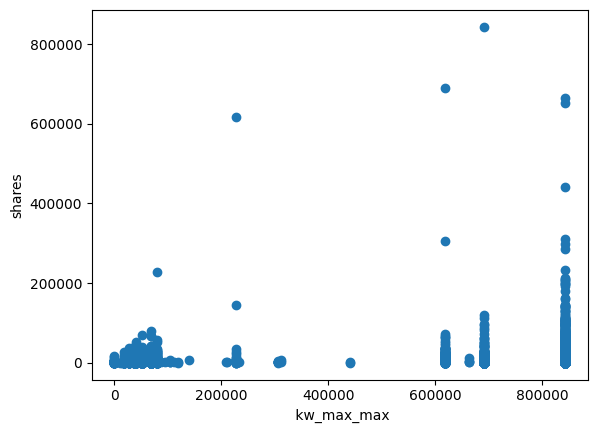

Linear Regression


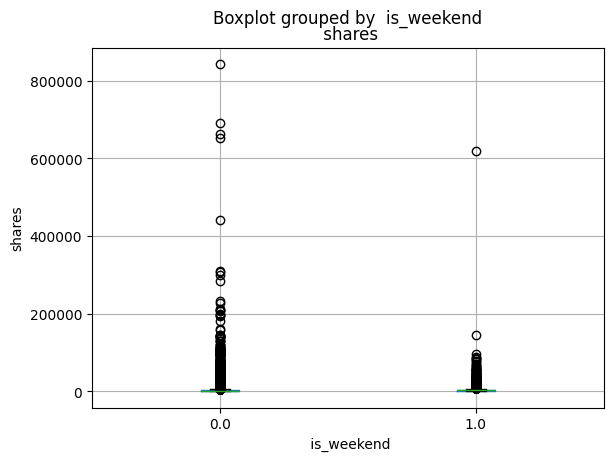

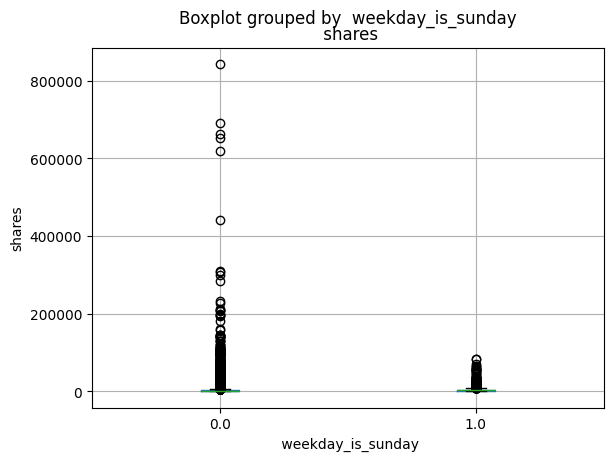

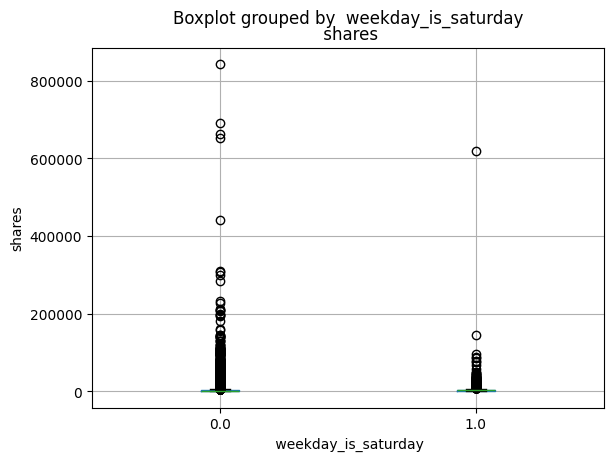

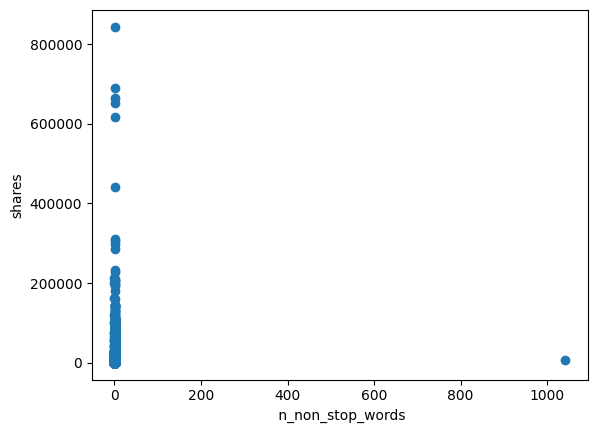

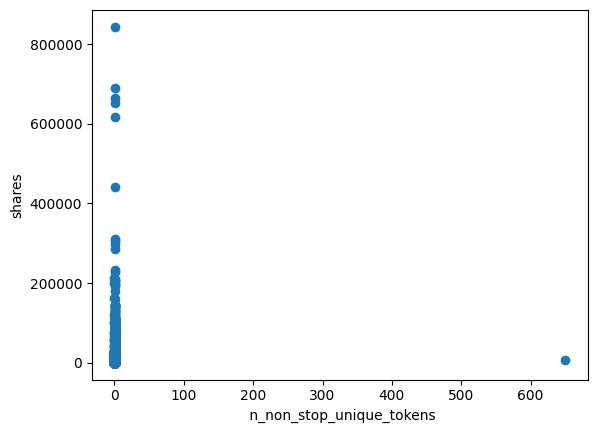

In [5]:
#pick the top 5 features from the linear regression and decision tree models. Then plot them against the target variable.
import matplotlib.pyplot as plt
top_features = importances.index[:5]
print('Decision Tree')
for feature in top_features:
    # if the only values are 0 or 1 plot a boxplot
    if len(X[feature].unique()) == 2:
        dataset.boxplot(column=' shares', by=feature)
    else:
        plt.scatter(X[feature], shares)
    plt.xlabel(feature)
    plt.ylabel('shares')
    plt.show()
print('Linear Regression')
#pick the top 5 features from the linear regression and decision tree models. Then plot
# them against the target variable.
top_features = coefficients.index[:5]
for feature in top_features:
    if len(X[feature].unique()) == 2:
        dataset.boxplot(column=' shares', by=feature)
    else:
        plt.scatter(X[feature], shares)
    plt.xlabel(feature)
    plt.ylabel('shares')
    plt.show()

# Linear Regression Modeling

In [ ]:
from sklearn.linear_model import LassoCV

shares = dataset[' shares']
logged_y = shares.apply(lambda x: 0 if x == 0 else np.log(x))
X = dataset.drop(['url', ' timedelta', ' shares'], axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, logged_y, test_size=0.2, random_state=42)

# LASSO regression
lasso_model = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state=42, max_iter=10000)
lasso_model.fit(X_train, y_train)

# Evaluate LASSO model
lasso_predictions = lasso_model.predict(X_test)
lasso_r2 = r2_score(y_test, lasso_predictions)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Extract significant features
lasso_coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
significant_features = lasso_coefficients[lasso_coefficients != 0]

#### LASSO Regression Results
print(f"Best alpha (α): {lasso_model.alpha_:.5f}")
print(f"Out-of-sample R²: {lasso_r2:.5f}")
print(f"Out-of-sample MSE: {lasso_mse:.5f}")
print(f"Number of significant predictors: {len(significant_features)}")

#### Most Significant Predictors (LASSO)
{significant_features.sort_values(ascending=False).to_string()}

c:\Users\sword\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9083070442247845, tolerance: 2.2034755111820727
  model = cd_fast.enet_coordinate_descent_gram(


Best alpha (α): 0.00041
Out-of-sample R²: 0.12752
Out-of-sample MSE: 0.74882
Number of significant predictors: 52


{'kw_avg_avg                       0.415565\nis_weekend                       0.092832\nLDA_00                           0.081502\nkw_min_min                       0.059993\nglobal_subjectivity              0.050752\nkw_max_min                       0.050556\ndata_channel_is_tech             0.048598\nnum_hrefs                        0.048037\ndata_channel_is_socmed           0.045381\nLDA_04                           0.033828\nself_reference_avg_sharess       0.029634\nabs_title_subjectivity           0.029314\nrate_positive_words              0.029125\nnum_imgs                         0.028733\nself_reference_min_shares        0.027470\nweekday_is_friday                0.026425\nnum_keywords                     0.024260\nweekday_is_monday                0.023956\ntitle_subjectivity               0.022309\nn_tokens_content                 0.021905\ntitle_sentiment_polarity         0.019145\nn_tokens_title                   0.018207\nnum_videos                       0.009962\nabs_title

## Model Results

Out-of-Sample Performance:
The LASSO regression model was tuned using cross-validation to optimize the regularization parameter, 
𝛼. The best α value obtained was 0.00041, which balances model complexity and predictive performance.

Out-of-sample 𝑅^2: 0.12752
Out-of-sample MSE: 0.74882
Number of Significant Predictors: 52
These metrics indicate that the model captures some of the variance in the number of shares but leaves a significant portion unexplained, suggesting that the model has limited predictive power. The relatively low R^2 value highlights the challenges in predicting shares, which may be influenced by factors not included in the dataset.

Significant Predictors:
The LASSO regression identified 52 predictors as significant. Below are the most impactful variables, sorted by their absolute coefficient values:

kw_avg_avg (0.4156): This feature, representing the average keyword score, had the highest positive influence on shares. It suggests that the quality of keywords is a strong driver of article popularity.
is_weekend (0.0928): Articles published on weekends tend to receive more shares, indicating timing is an essential factor in content sharing.
LDA_00 (0.0815): Topic modeling feature 0, likely capturing a specific thematic focus, positively influenced shares.
kw_min_min (0.0600): The minimum keyword score also played a positive role, suggesting a broad keyword range might contribute to higher shares.
global_subjectivity (0.0508): Articles with higher subjectivity levels appeared to attract more shares, indicating that emotional or opinion-driven content resonates with readers.

Negative predictors included:
kw_max_avg (-0.2378): Articles with a high maximum average keyword score negatively influenced shares, potentially due to over-optimization of keywords.
data_channel_is_entertainment (-0.0651): Content in the entertainment category showed a negative association with shares, which may indicate a saturation of such content.
average_token_length (-0.0584): Longer average word lengths were associated with fewer shares, possibly due to reduced readability.
Model Usefulness for Predicting Future Shares
While the model identifies key predictors of article shares, its R^2 value of 0.12752 suggests it explains only a small portion of the variance. The high number of significant predictors indicates a complex relationship between features and shares, but the overall predictive power remains modest.

This model is useful for gaining insights into factors that influence article popularity. For example, optimizing keyword quality (kw_avg_avg) and strategically timing article publication (is_weekend) can improve shares. However, its ability to precisely predict future shares is limited, and additional data or alternative modeling techniques might be necessary for better performance.